Preprocessing the [MultiEURLEX dataset](https://huggingface.co/datasets/coastalcph/multi_eurlex)

MultiEURLEX comprises 65k EU laws in 23 official EU languages. Each EU law has been annotated with EUROVOC concepts (labels) by the Publication Office of EU.

In [ ]:
from datasets import load_dataset, concatenate_datasets
import pandas as pd

# Load English dataset
dataset_en = load_dataset("coastalcph/multi_eurlex", "en", trust_remote_code=True)

# Load Dutch dataset
dataset_nl = load_dataset("coastalcph/multi_eurlex", "nl", trust_remote_code=True)

# Combine train/test/validation splits for both languages
combined_en = concatenate_datasets([dataset_en[split] for split in dataset_en])
combined_nl = concatenate_datasets([dataset_nl[split] for split in dataset_nl])

# Convert to Pandas DataFrames
df1 = pd.DataFrame(combined_en)
df2 = pd.DataFrame(combined_nl)

# Combine them into the first DataFrame (df1)
df1.insert(2, "text_nl", df2["text"])
df1.rename(columns={"text": "text_en"}, inplace=True)

# Add an extra column with the first item of the EUROVOC labels
df1["first_label"] = df1["labels"].apply(lambda x: x[0]) 

In [3]:
df1

,celex_id,text_en,text_nl,labels,first_label
0,32006D0213,COMMISSION DECISION\nof 6 March 2006\nestablis...,BESCHIKKING VAN DE COMMISSIE\nvan 6 maart 2006...,"[1, 20, 7, 3, 0]",1
1,32003R1330,Commission Regulation (EC) No 1330/2003\nof 25...,Verordening (EG) nr. 1330/2003 van de Commissi...,"[2, 17]",2
2,32003R1786,Council Regulation (EC) No 1786/2003\nof 29 Se...,Verordening (EG) nr. 1786/2003 van de Raad\nva...,"[3, 19, 6]",3
3,31985R2590,*****\nCOMMISSION REGULATION (EEC) No 2590/85\...,*****\nVERORDENING (EEG) Nr. 2590/85 VAN DE CO...,"[12, 17, 19, 6]",12
4,31993R1103,COMMISSION REGULATION (EEC) No 1103/93 of 30 A...,VERORDENING (EEG) Nr. 1103/93 VAN DE COMMISSIE...,"[18, 3, 4, 1]",18
...,...,...,...,...,...
64995,32011D0151,COMMISSION DECISION\nof 3 March 2011\namending...,BESLUIT VAN DE COMMISSIE\nvan 3 maart 2011\nto...,"[4, 11, 5, 0, 12, 15]",4
64996,32010D0256,COMMISSION DECISION\nof 30 April 2010\namendin...,BESLUIT VAN DE COMMISSIE\nvan 30 april 2010\nt...,"[12, 0, 6]",12
64997,32010D0177,COMMISSION DECISION\nof 23 March 2010\namendin...,BESLUIT VAN DE COMMISSIE\nvan 23 maart 2010\nt...,"[1, 4, 0, 3, 18]",1
64998,32012R0307,COMMISSION IMPLEMENTING REGULATION (EU) No 307...,UITVOERINGSVERORDENING (EU) Nr. 307/2012 VAN D...,"[0, 3, 17, 15]",0


In [ ]:
# checking and visualising the variation in document length by making an extra column with the wordcounts of the English documents

df1['doc_length_eng'] = df1['text_en'].str.split().str.len()  # word count

print(f'Mean document length: {df1['doc_length_eng'].mean()}')
print(f'Median document length: {df1['doc_length_eng'].median()}')

Mean document length: 1197.8520307692309
Median document length: 455.0


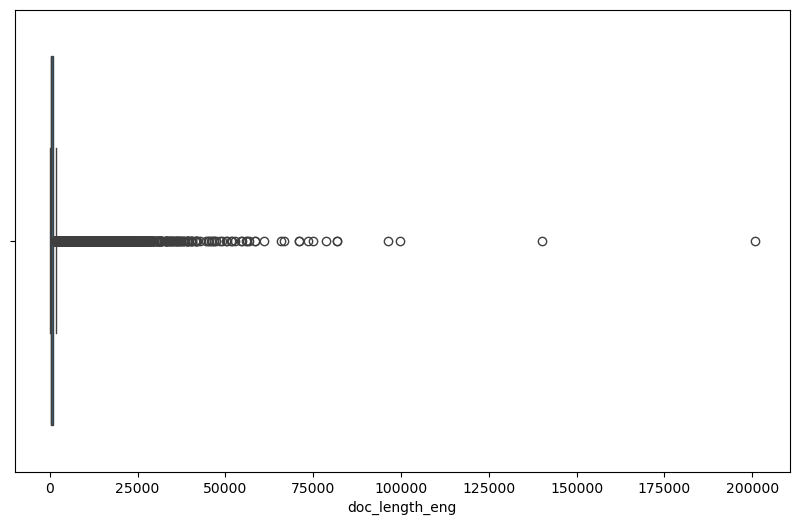

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x=df1['doc_length_eng'])
plt.show()

In [6]:
# calculate interquartile range and remove outliers

import numpy as np

Q1 = df1['doc_length_eng'].quantile(0.25)
Q3 = df1['doc_length_eng'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

print(f'The upper bound is: {upper_bound} words')

df1_filtered = df1[df1['doc_length_eng'] <= upper_bound]

print(f"original number of documents: {len(df1)}")
print(f"number of documents without outliers: {len(df1_filtered)}") # I lost 13% of the original data. Is that too much?

The upper bound is: 1746.5 words
original number of documents: 65000
number of documents without outliers: 56825


Mean document length: 532.6521425428948
Median document length: 414.0


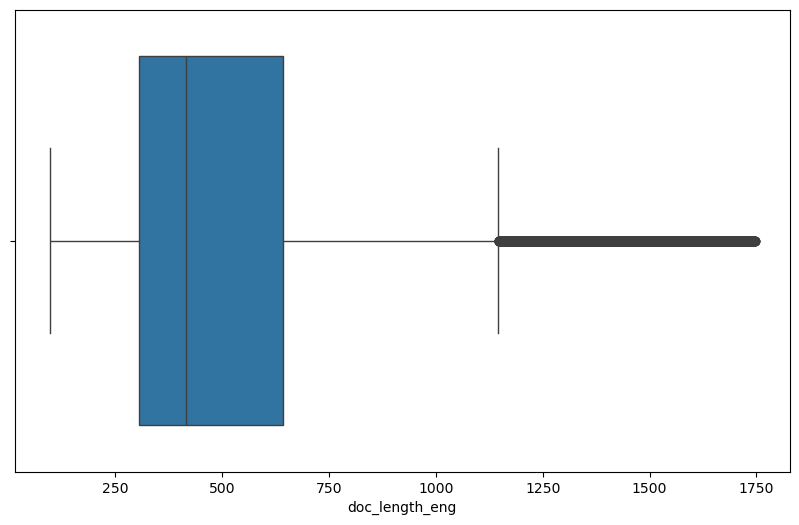

In [7]:
print(f'Mean document length: {df1_filtered['doc_length_eng'].mean()}')
print(f'Median document length: {df1_filtered['doc_length_eng'].median()}')

# mean and median are a lot closer

plt.figure(figsize=(10, 6))
sns.boxplot(x=df1_filtered['doc_length_eng'])
plt.show()

In [ ]:
# we take a sample from the data to evaluate BM25 on 
# to ensure diversity we keep the distribution of the EUROVOC labels we stored in first_label

from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=1500)

# The .split() method returns indices for the training and test sets. Because we set n_splits=1, it only runs once. 

# We only care about the test set (our sample of 1500 rows).
# so we ignore train_idx and use the sample indices to select the stratified sample from the original data.
# .copy() so we do not modify the original DataFrame
for train_idx, sample_idx in splitter.split(df1_filtered, df1_filtered["first_label"]):
    stratified_sample_df = df1_filtered.iloc[sample_idx].copy()

In [10]:
# reset index so this will later align with series of formatted prompts

stratified_sample_df = stratified_sample_df.reset_index(drop=True)

In [ ]:
# save as csv file

stratified_sample_df.to_csv('data/stratified_sample.csv', index=False)

df1_filtered.to_csv('data/corpus_without_outliers.csv', index=False)